In [132]:
# Importing all necessary packages

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt 
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score


from datasist.structdata import detect_outliers

from io import StringIO
import pydotplus
from IPython.display import Image

%matplotlib inline

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


from sklearn.ensemble import RandomForestRegressor

from sklearn.inspection import permutation_importance

In [134]:
# Part 1: Reading the data and doing exploratory analysis

# Read data from a CSV file into a data frame

df = pd.read_csv('train.csv')


pd.set_option('display.max_columns', 500)

# Display the first ten rows of the data frame to examine if it is an individual-level data set
print(df.head(10))


# Display the variable list
print(df.columns.values)

# Display the number of rows and the number of columns 
print(df.shape)

       ID Customer_ID     Month             Name   Age          SSN  \
0  0x1602   CUS_0xd40   January    Aaron Maashoh    23  821-00-0265   
1  0x1603   CUS_0xd40  February    Aaron Maashoh    23  821-00-0265   
2  0x1604   CUS_0xd40     March    Aaron Maashoh  -500  821-00-0265   
3  0x1605   CUS_0xd40     April    Aaron Maashoh    23  821-00-0265   
4  0x1606   CUS_0xd40       May    Aaron Maashoh    23  821-00-0265   
5  0x1607   CUS_0xd40      June    Aaron Maashoh    23  821-00-0265   
6  0x1608   CUS_0xd40      July    Aaron Maashoh    23  821-00-0265   
7  0x1609   CUS_0xd40    August              NaN    23    #F%$D@*&8   
8  0x160e  CUS_0x21b1   January  Rick Rothackerj   28_  004-07-5839   
9  0x160f  CUS_0x21b1  February  Rick Rothackerj    28  004-07-5839   

  Occupation Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0  Scientist      19114.12            1824.843333                  3   
1  Scientist      19114.12                    NaN                  3   
2 

/Users/safwaan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3442: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [135]:
#Dropping redundant columns which will not be used as predictors from the dataset 

redu_columns = ['ID', 'Customer_ID', 'Month', 'Name', 'SSN']

df_sample1 = df.drop(redu_columns, axis = 1).copy()

df_sample1.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,23,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,23,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,-500,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,23,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,23,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [136]:
# We can see below that Age, Annual Income, Num_of_Loan, Num_of_Delayed_Payment, Changed_Credit_Limit, Outstanding_Debt
# Credit_History_Age, Amount_invested_monthly and Monthly_Balance are classified as object when they should be floats
# This needs to be looked into
df_sample1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       100000 non-null  object 
 1   Occupation                100000 non-null  object 
 2   Annual_Income             100000 non-null  object 
 3   Monthly_Inhand_Salary     84998 non-null   float64
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_Credit_Card           100000 non-null  int64  
 6   Interest_Rate             100000 non-null  int64  
 7   Num_of_Loan               100000 non-null  object 
 8   Type_of_Loan              88592 non-null   object 
 9   Delay_from_due_date       100000 non-null  int64  
 10  Num_of_Delayed_Payment    92998 non-null   object 
 11  Changed_Credit_Limit      100000 non-null  object 
 12  Num_Credit_Inquiries      98035 non-null   float64
 13  Credit_Mix                100000 non-null  ob

In [137]:
# Seeing what the values in the columns categorized as objects when they should be numercial columns 
# look like to assist in data cleaning. The main issue appears to be the use of special characters like _ being 
# thrown into different data entries. We will need to filter for that.

df_sample1.describe(exclude=np.number).T

,count,unique,top,freq
Age,100000,1788,38,2833
Occupation,100000,16,_______,7062
Annual_Income,100000,18940,36585.12,16
Num_of_Loan,100000,434,3,14386
Type_of_Loan,88592,6260,Not Specified,1408
Num_of_Delayed_Payment,92998,749,19,5327
Changed_Credit_Limit,100000,4384,_,2091
Credit_Mix,100000,4,Standard,36479
Outstanding_Debt,100000,13178,1360.45,24
Credit_History_Age,90970,404,15 Years and 11 Months,446


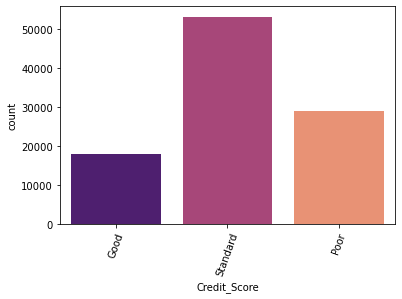

In [138]:
# Visualizing the target variable. The spread seems quite skewed towards 'Standard'. Will apply SMOTE to compensate for
# the imbalance as well as map the data into a binary variable to allow for logistic regression analysis

sns.countplot(df_sample1['Credit_Score'],palette="magma")
plt.xticks(rotation=70);

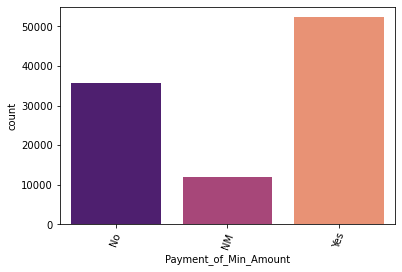

In [139]:
# We can see that Payment_of_Min_Amount has several entries labelled ‘NM’, which might be a spelling error
sns.countplot(df_sample1['Payment_of_Min_Amount'],palette="magma");
plt.xticks(rotation=70);

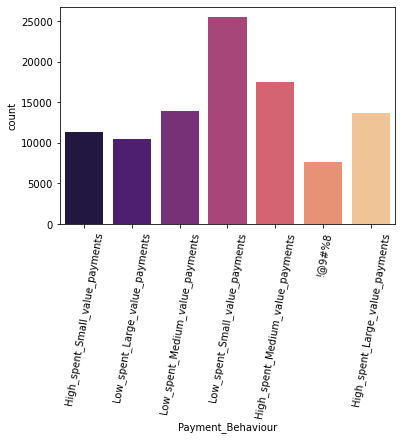

In [140]:
# Payment_Behaviour has an irregular value with just special characters. This needs to be dealt with.

sns.countplot(df_sample1['Payment_Behaviour'],palette="magma");
plt.xticks(rotation=80);

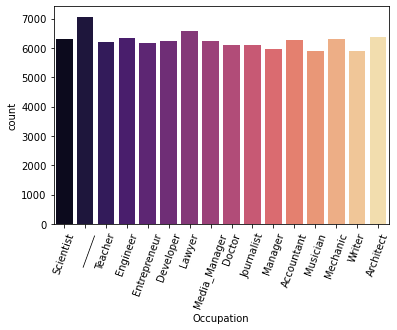

In [141]:
# Occupation has a several rows with the label '________' which does not make sense

sns.countplot(df_sample1['Occupation'],palette="magma");
plt.xticks(rotation=70);

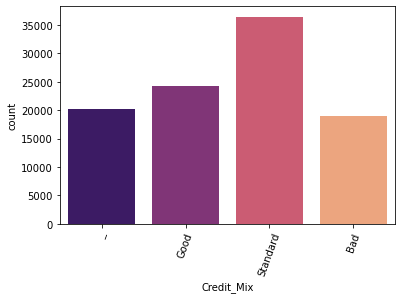

In [142]:
# Credit_Mix appear to have mislabled values of '_'

sns.countplot(df_sample1['Credit_Mix'],palette="magma");
plt.xticks(rotation=70);

In [143]:
#  Part 2: Data Cleaning and Preprocessing
#  Loop through all columns and replace special characters with empty string

def rem_special_ch(d):
    
    special_chars = [ '#', '$', '&', '_','!', '@']
    if d == '':
        return np.nan
    else:
        return ''.join(c for c in d if c not in special_chars)

# apply the function to all rows in the dataframe
df_sample2 = df_sample1.applymap(lambda x: rem_special_ch(x) if isinstance(x, str) else x).copy()


In [144]:
# Turning our numerical columns into float 

num_cols = ['Num_of_Loan',  'Num_of_Delayed_Payment', 'Outstanding_Debt',
'Amount_invested_monthly', 'Monthly_Balance', 'Age',  'Annual_Income' ]

df_sample2[num_cols] = df_sample2[num_cols].astype('float64')

In [145]:
# Turning the last column which we were not able to process with our self defined function into a format we can
# convert to float

df_sample2['Changed_Credit_Limit'] = df_sample2['Changed_Credit_Limit'].replace('', np.nan)


df_sample2['Changed_Credit_Limit'] = df_sample2['Changed_Credit_Limit'].astype('float64')



(100000, 23)

In [146]:
# Checking how everything is looking at this stage. We can see below that we now need to tend to occupation, type of 
# loan, credit mix, payment of min amount, payment behaviour, Credit_Score
df_sample2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       100000 non-null  float64
 1   Occupation                100000 non-null  object 
 2   Annual_Income             100000 non-null  float64
 3   Monthly_Inhand_Salary     84998 non-null   float64
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_Credit_Card           100000 non-null  int64  
 6   Interest_Rate             100000 non-null  int64  
 7   Num_of_Loan               100000 non-null  float64
 8   Type_of_Loan              88592 non-null   object 
 9   Delay_from_due_date       100000 non-null  int64  
 10  Num_of_Delayed_Payment    92998 non-null   float64
 11  Changed_Credit_Limit      97909 non-null   float64
 12  Num_Credit_Inquiries      98035 non-null   float64
 13  Credit_Mix                100000 non-null  ob

In [147]:
# Function to convert Credit_History_Age into a numerical value with the total no. of months instead of the years and
# months format

def age_converter(x):
    if pd.isna(x):
        return np.nan
    elif 'Years' in x:
        years, months = x.split(' Years and ')
        months = months.replace(' Months', '')
        months = int(months) if months else 0
        return int(years) * 12 + months
    elif 'Months' in x:
        months = x.replace(' Months', '')
        return int(months)
    else:
        years = x.replace(' Years', '')
        return int(years) * 12

# apply the age_converter() function to the 'Credit_History_Age' column of the dataframe
df_sample2['Credit_History_Age'] = df_sample2['Credit_History_Age'].apply(age_converter)


In [148]:
# Turning the Credit_History_Age column into float 

df_sample2['Credit_History_Age'].astype('float64')

0        265.0
1          NaN
2        267.0
3        268.0
4        269.0
         ...  
99995    378.0
99996    379.0
99997    380.0
99998    381.0
99999    382.0
Name: Credit_History_Age, Length: 100000, dtype: float64

In [149]:
# Part 3: Missing value imputation, handling of outliers and additional preprocessing

# Finding the mode from the original data for 'Payment_Behaviour'

PB_mode = df_sample1['Payment_Behaviour'].mode()

# Replacing the irregular value with the mode

df_sample2['Payment_Behaviour']= df_sample2['Payment_Behaviour'].replace('9%8', PB_mode[0])

# Printing the unique values in the dataset now
df_sample2['Payment_Behaviour'].unique()


array(['HighspentSmallvaluepayments', 'LowspentLargevaluepayments',
       'LowspentMediumvaluepayments', 'LowspentSmallvaluepayments',
       'HighspentMediumvaluepayments', 'Low_spent_Small_value_payments',
       'HighspentLargevaluepayments'], dtype=object)

In [119]:
# Printing out Num_Bank_Accounts. We see a lot of outliers and some negative values.

df_sample2['Num_Bank_Accounts'].unique()

array([   3,    2,    1,    7,    4,    0,    8,    5,    6,    9,   10,
       1414, 1231,   67,  572, 1488,   91,  528, 1647, 1696, 1338,  649,
        889, 1668,  685,  857,  975, 1496, 1534, 1620,   37, 1388, 1429,
       1332, 1588,  120, 1777, 1096,  803,  494,  744, 1139,  831, 1613,
        741,  121,  665, 1748, 1644,  823, 1356, 1651,   87,  711,  450,
        210, 1671, 1722,  648,  672, 1662, 1495,  510,  666,  429, 1131,
       1434,  980, 1026,  526,  718, 1300, 1312, 1315,  501, 1566,  480,
       1042,  322,  628, 1016,  333, 1265,  791,  427,  563,  905, 1190,
       1036, 1611,   38,  619,  555, 1769,  280,  752, 1201,  812, 1487,
        222,  212, 1019, 1222,  610, 1714, 1308,  525, 1158, 1115, 1616,
        754, 1601,  797, 1577,  521,  703,  933,  959,  809, 1089, 1656,
       1113, 1715,  964, 1533, 1789,  871,  434, 1295,  565, 1724,  603,
        677,  541,  698, 1101,  464, 1539, 1462, 1011, 1257, 1727,   45,
        244, 1266,  897,  535,  484,  331,  675,  8

In [150]:
# Num_Bank_Accounts: Getting rid of the negative numbers which must be an error for this column

df_sample3 = df_sample2.copy()

df_sample3['Num_Bank_Accounts'] = df_sample2['Num_Bank_Accounts'].apply(lambda x :abs (x))

In [121]:
# Occupation. We see from checking the unique values and the value counts that the empty value actually has the highest
# count out of all the occupations

print(df_sample2['Occupation'].unique())

df_sample3['Occupation'].value_counts()

['Scientist' '' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'MediaManager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect']


                7062
Lawyer          6575
Architect       6355
Engineer        6350
Scientist       6299
Mechanic        6291
Accountant      6271
Developer       6235
MediaManager    6232
Teacher         6215
Entrepreneur    6174
Doctor          6087
Journalist      6085
Manager         5973
Musician        5911
Writer          5885
Name: Occupation, dtype: int64

In [151]:
# Occupation: Replacing the irregular value with 'Lawyer' which we saw is the second most common occupation after 
# the irregular value

df_sample3['Occupation']= df_sample3['Occupation'].replace('', 'Lawyer')

df_sample3['Occupation'].unique()

array(['Scientist', 'Lawyer', 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'MediaManager', 'Doctor', 'Journalist', 'Manager',
       'Accountant', 'Musician', 'Mechanic', 'Writer', 'Architect'],
      dtype=object)

In [152]:
# Payment_of_Min_Amount: This is most likely a spelling error for No, so we fix the error below 

df_sample3['Payment_of_Min_Amount'].replace("NM","No",inplace=True)

In [153]:
# Credit_Mix: finding the mode from the original data

CM_mode = df_sample1['Credit_Mix'].mode()

# Replacing the irregular value with the mode

df_sample3['Credit_Mix']= df_sample2['Credit_Mix'].replace('', CM_mode[0])

df_sample3['Credit_Mix'].unique()


array(['Standard', 'Good', 'Bad'], dtype=object)

In [154]:
# Imputting the median for all the numerical values that are missing in the dataset

median_values = df_sample3.median()

df_sample4 = df_sample3.copy()

df_sample4 = df_sample4.fillna(value=median_values)

In [155]:
# Dropping type_of_loan from dataset as it does not tell us much given many rows are a combination of loans rather
# than just 1 type of loan that has been applied for

df_sample5 = df_sample4.copy()

df_sample5 = df_sample4.drop('Type_of_Loan', axis = 1)


In [156]:
# Summary of dataset at this stage. The Non-Null Counts finally match up

df_sample5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       100000 non-null  float64
 1   Occupation                100000 non-null  object 
 2   Annual_Income             100000 non-null  float64
 3   Monthly_Inhand_Salary     100000 non-null  float64
 4   Num_Bank_Accounts         100000 non-null  int64  
 5   Num_Credit_Card           100000 non-null  int64  
 6   Interest_Rate             100000 non-null  int64  
 7   Num_of_Loan               100000 non-null  float64
 8   Delay_from_due_date       100000 non-null  int64  
 9   Num_of_Delayed_Payment    100000 non-null  float64
 10  Changed_Credit_Limit      100000 non-null  float64
 11  Num_Credit_Inquiries      100000 non-null  float64
 12  Credit_Mix                100000 non-null  object 
 13  Outstanding_Debt          100000 non-null  fl

In [157]:
# Handling Outliers: First, we divide the columns into numerical and categorical lists

cat_cols = ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score']

num_cols = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate',
            'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment','Changed_Credit_Limit','Num_Credit_Inquiries',
           'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age','Total_EMI_per_month',
           'Amount_invested_monthly', 'Monthly_Balance']

In [159]:
# Handling outliers for all the numerical columns in the dataset using the detect_outliers function we imported
for col in num_cols :
    outliers_indicies = detect_outliers(df_sample5,0,[col])
    median = df_sample5[col].median()
    df_sample5[col].iloc[outliers_indicies] = median

In [160]:
# Additional preprocessing: Setting the type of the categorical colums in our dataset to category

for i in cat_cols:
    df_sample5[i].astype('category')

In [161]:
# Additional preprocessing:Turning our target variable, Credit_Score into a binary variable so that we can do 
# logistic regression. Here, we are making it so that we're basically only distiguishing between poor and not poor 
# credit scores, by turning the 3 classes of our variable into just 2

df_sample5['Credit_Score'].unique()

target_map = {'Poor': 0, 'Standard': 1, 'Good': 1}
df_sample5['target'] = df_sample5['Credit_Score'].map(target_map)

In [162]:
# Additional preprocessing: Dropping the Credit_Score column as we no longer need it and turning the target into a
# categorical variable
df_sample6 = df_sample5.copy()

df_sample6 = df_sample5.drop('Credit_Score', axis = 1)

df_sample6['target'].astype('category')

0        1
1        1
2        1
3        1
4        1
        ..
99995    0
99996    0
99997    0
99998    1
99999    0
Name: target, Length: 100000, dtype: category
Categories (2, int64): [0, 1]

In [163]:
# Additional preprocessing: Standardizing the numerical variables 
df_sample7 = df_sample6.copy()
df_sample7[num_cols] = (df_sample6[num_cols] - df_sample6[num_cols].mean())/df_sample6[num_cols].std()

In [164]:
df_sample7.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,target
0,-0.971017,Scientist,-0.837306,-0.775319,-0.922193,-0.743638,-1.329054,0.204279,-1.373124,-1.049763,0.205104,-0.465483,Standard,-0.44801,-1.067666,0.462538,No,-0.43681,-0.704819,HighspentSmallvaluepayments,-0.230369,1
1,-0.971017,Scientist,-0.837306,-0.144492,-0.922193,-0.743638,-1.329054,0.204279,-1.730005,0.104283,0.205104,-0.465483,Good,-0.44801,-0.066368,-0.020993,No,-0.43681,-0.157303,LowspentLargevaluepayments,-0.508333,1
2,-0.029298,Scientist,-0.837306,-0.144492,-0.922193,-0.743638,-1.329054,0.204279,-1.373124,-1.049763,-0.096677,-0.465483,Good,-0.44801,-0.718401,0.483561,No,-0.43681,-0.686250,LowspentMediumvaluepayments,-0.043671,1
3,-0.971017,Scientist,-0.837306,-0.144492,-0.922193,-0.743638,-1.329054,0.204279,-1.194683,-1.544354,-0.601797,-0.465483,Good,-0.44801,-0.177223,0.494072,No,-0.43681,1.016507,LowspentSmallvaluepayments,-1.118608,1
4,-0.971017,Scientist,-0.837306,-0.775319,-0.922193,-0.743638,-1.329054,0.204279,-1.105463,0.104283,0.205104,-0.465483,Good,-0.44801,-1.463559,0.504584,No,-0.43681,-1.268678,HighspentMediumvaluepayments,0.058870,1


In [165]:
# Convert the categorical variables into dummies (Step 1 of dummy coding)
# prefix_sep is the sympol used to create the dummy variable names.

df_sample8 = df_sample7.copy()
df_sample8 = pd.get_dummies(df_sample7, prefix_sep='_')


#df_sample8.head()
# Remove the redundant dummies 
# Placeholder variable: rdummies
rdummies = ['Occupation_Accountant','Credit_Mix_Bad', 'Payment_of_Min_Amount_No', 'Payment_Behaviour_HighspentLargevaluepayments']
df_sample9 = df_sample8.copy()
df_sample9 = df_sample8.drop(columns=rdummies)

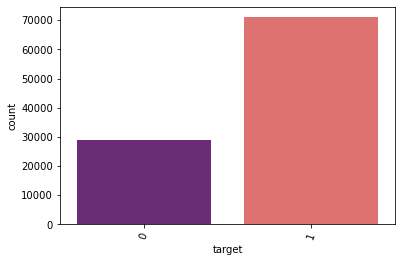

In [166]:
# Checking for imbalance in data set for the target variable. We are going to use SMOTE to address this issue
sns.countplot(df_sample9['target'],palette="magma")
plt.xticks(rotation=70);

In [167]:
# Part 4: Feature Importance. Method adopted from the article below:
# https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285
# Note: This code takes between 5-10 minutes to run

df4partition = df_sample9

testpart_size = 0.2

X = df4partition.drop(columns = 'target', axis = 1)
y = df4partition['target']




rf = RandomForestRegressor(n_estimators=150)
rf.fit(X,y)

RandomForestRegressor(n_estimators=150)

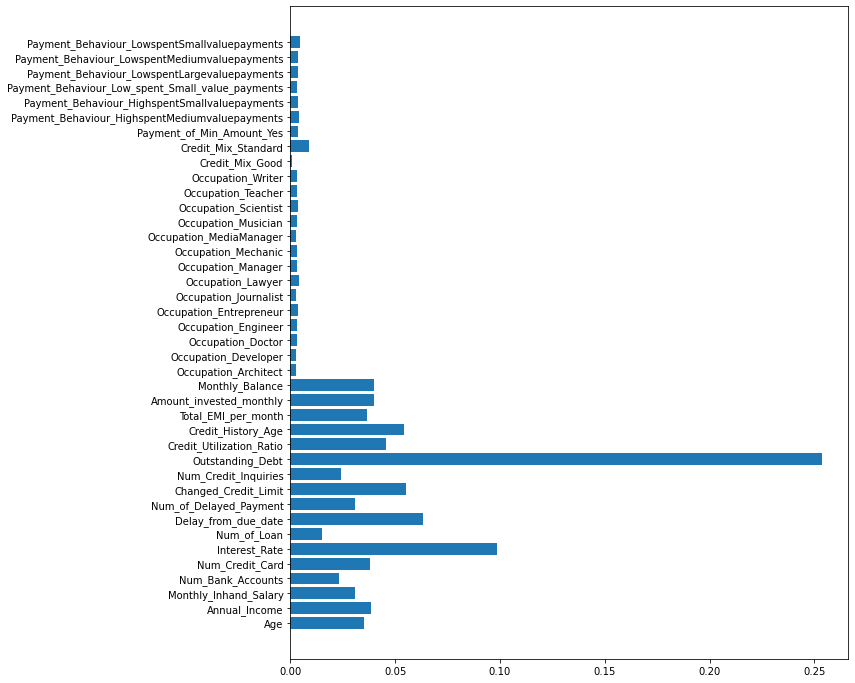

In [168]:
# We see from the graph below that the Payment Behaviour, Occupation and the number of credit cards, loans, and accounts
# appear to be less relevant when it comes to predicting the target variable, so we will drop them before creating
# our main models

fig, ax = plt.subplots(figsize=(10, 12)) # adjust the size of the figure as needed


ax.barh(X_train_smote.columns, rf.feature_importances_)

plt.show()

In [169]:
# 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testpart_size, random_state = 1)


smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


X_train_smote.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Occupation_Architect,Occupation_Developer,Occupation_Doctor,Occupation_Engineer,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,Occupation_MediaManager,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer,Credit_Mix_Good,Credit_Mix_Standard,Payment_of_Min_Amount_Yes,Payment_Behaviour_HighspentMediumvaluepayments,Payment_Behaviour_HighspentSmallvaluepayments,Payment_Behaviour_Low_spent_Small_value_payments,Payment_Behaviour_LowspentLargevaluepayments,Payment_Behaviour_LowspentMediumvaluepayments,Payment_Behaviour_LowspentSmallvaluepayments
0,-0.029298,-0.033806,0.168216,1.018154,0.234055,-0.982358,-0.213086,-0.480921,-0.060581,1.079785,0.350109,-1.047708,1.440865,-0.273270,-0.130351,0.097846,0.675473,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1,0.629905,-0.454719,-0.423539,-0.534123,0.234055,0.173296,-0.630450,-1.016242,0.598874,-0.316154,-0.193619,-1.368847,0.268913,-0.346851,-0.130373,0.097846,0.520022,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,-1.253532,-0.241228,0.029000,1.018154,-0.254792,1.791212,0.204279,-0.034819,1.423192,-0.133795,1.165701,1.939785,0.142283,-0.220712,-0.130351,1.231184,-0.415096,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,-0.029298,1.066983,1.634188,1.794293,-0.254792,1.097819,2.291103,1.838807,1.093465,-0.879371,0.078245,0.277789,-0.523979,0.010541,-0.130373,-0.604206,1.663384,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
4,-0.405985,-0.911385,-0.954440,-0.534123,-0.254792,0.519992,1.456374,0.232842,0.598874,0.995867,-0.193619,0.350283,-0.399381,-0.020993,0.168809,-1.287735,-0.675245,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0


In [170]:


X_train_smote1 = X_train_smote.copy()
X_test1 = X_test.copy()


irrev_cols = ['Payment_of_Min_Amount_Yes','Payment_Behaviour_HighspentMediumvaluepayments','Payment_Behaviour_HighspentSmallvaluepayments', 'Payment_Behaviour_Low_spent_Small_value_payments', 'Payment_Behaviour_LowspentLargevaluepayments', 'Payment_Behaviour_LowspentMediumvaluepayments',
              'Payment_Behaviour_LowspentSmallvaluepayments', 'Occupation_Architect', 'Occupation_Developer',
              'Occupation_Doctor', 'Occupation_Engineer', 'Occupation_Entrepreneur', 'Occupation_Journalist',
              'Occupation_Lawyer', 'Occupation_Manager', 'Occupation_Mechanic', 'Occupation_MediaManager',
              'Occupation_Musician', 'Occupation_Scientist', 'Occupation_Teacher', 'Occupation_Writer', 'Num_Credit_Card',
              'Num_Bank_Accounts', 'Num_of_Loan']


X_train_smote1 = X_train_smote.drop(irrev_cols, axis = 1)

X_test1 = X_test.drop(irrev_cols, axis = 1)

X_train_smote1.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Interest_Rate,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Mix_Good,Credit_Mix_Standard
0,-0.029298,-0.033806,0.168216,-0.982358,-0.480921,-0.060581,1.079785,0.350109,-1.047708,1.440865,-0.273270,-0.130351,0.097846,0.675473,0,1
1,0.629905,-0.454719,-0.423539,0.173296,-1.016242,0.598874,-0.316154,-0.193619,-1.368847,0.268913,-0.346851,-0.130373,0.097846,0.520022,0,1
2,-1.253532,-0.241228,0.029000,1.791212,-0.034819,1.423192,-0.133795,1.165701,1.939785,0.142283,-0.220712,-0.130351,1.231184,-0.415096,0,0
3,-0.029298,1.066983,1.634188,1.097819,1.838807,1.093465,-0.879371,0.078245,0.277789,-0.523979,0.010541,-0.130373,-0.604206,1.663384,0,1
4,-0.405985,-0.911385,-0.954440,0.519992,0.232842,0.598874,0.995867,-0.193619,0.350283,-0.399381,-0.020993,0.168809,-1.287735,-0.675245,0,1


In [174]:
# Modelling- 1: Logistic Regression
# Below we see that by setting the alpha to 15000, we only have 3 predictors left, which we can say are the 3 most
# important features determining a credit score. They are interest rate on the credit card, level of outstanding
# debt and number of inquiries an individual has made for a credit card

alpha = 15000

clf = LogisticRegression(C = 1/alpha, penalty = 'l1', solver = 'saga', max_iter = 20000, random_state = 1).fit(X_train_smote1,y_train_smote)


def summary_coef(model_object):
  n_predictors = X_train_smote1.shape[1]
  model_coef = pd.DataFrame(model_object.coef_.reshape(1, n_predictors), columns = X_train_smote1.columns.values)
  model_coef['Intercept'] = model_object.intercept_
  return model_coef.transpose()


print(summary_coef(clf))


                                 0
Age                       0.000000
Annual_Income             0.000000
Monthly_Inhand_Salary     0.000000
Interest_Rate            -0.182009
Delay_from_due_date       0.000000
Num_of_Delayed_Payment    0.000000
Changed_Credit_Limit      0.000000
Num_Credit_Inquiries     -0.063966
Outstanding_Debt         -0.230545
Credit_Utilization_Ratio  0.000000
Credit_History_Age        0.000000
Total_EMI_per_month       0.000000
Amount_invested_monthly   0.000000
Monthly_Balance           0.000000
Credit_Mix_Good           0.000000
Credit_Mix_Standard       0.000000
Intercept                 0.089481


In [176]:
# Modelling- 2: Knn with pre-specified k

k = 25

clf = KNeighborsClassifier(metric='euclidean', n_neighbors=k).fit(X_train_smote1,y_train_smote)

model_object = clf

# obtain the AUC of the k-NN model with k=5
print(metrics.roc_auc_score(y_test, model_object.predict_proba(X_test1)[:, 1]))

0.8613852800187447


In [173]:
# Modelling- 3 Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# create a random forest classifier model
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# train the model on the training set
rfc.fit(X_train_smote1, y_train_smote)

# make predictions on the testing set
y_pred = rfc.predict(X_test1)

# evaluate the performance of the model on the testing set
accuracy = rfc.score(X_test1, y_test)
print('Accuracy:', accuracy)

Accuracy: 0.87385
